In [1]:
##Vision Transformer (ViT)

# Dosovitskiy et. al. 2020

### Persiapan & Instalasi

!pip install scikit-learn

In [2]:
# Load semua library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

# Library tambahan
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Konfigurasi Device
print("PyTorch version:", torch.__version__)
print("timm version:", timm.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.9.0+cu126
timm version: 1.0.22
Using device: cuda


In [3]:
# Set random seed untuk hasil yang konsisten
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
# Fungsi bantuan untuk visualisasi (imshow)
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

    # --- Fungsi untuk Parameter Model ---
def count_parameters(model):
    """Menghitung total, trainable, dan non-trainable parameter."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def get_model_size(model):
    """Menghitung ukuran model dalam MB."""
    # Menghitung ukuran parameter dan buffer
    total_size = sum(p.numel() * p.element_size() for p in model.parameters()) + \
                 sum(b.numel() * b.element_size() for b in model.buffers())
    # Mengubah dari byte ke megabyte
    return total_size / (1024**2)

# --- Fungsi untuk Training dan Evaluasi ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    pbar = tqdm(dataloader, desc="Training")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total_correct += preds.eq(targets).sum().item()
        total_samples += targets.size(0)
        pbar.set_postfix(loss=total_loss/total_samples, acc=100*total_correct/total_samples)

    return total_loss / total_samples, total_correct / total_samples

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for images, targets in pbar:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total_correct += preds.eq(targets).sum().item()
            total_samples += targets.size(0)
            pbar.set_postfix(val_loss=total_loss/total_samples, val_acc=100*total_correct/total_samples)

    return total_loss / total_samples, total_correct / total_samples

In [5]:
# Persiapan dataset CIFAR-10 yang memiliki 10 kelas gambar berwarna kecil (32x32 piksel)
# Vision Transformer biasanya memerlukan ukuran 224x224, jadi gambar di-resize.

img_size = 224
batch_size = 16

# Vision Transformer memerlukan ukuran 224x224, jadi gambar di-resize.
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_ds.classes
print("\nKelas CIFAR-10:", classes)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]



Kelas CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


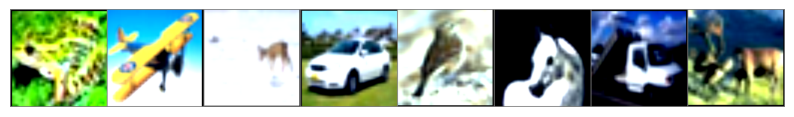

Labels: ['frog', 'airplane', 'deer', 'automobile', 'bird', 'horse', 'truck', 'deer']


In [6]:
# Visualisasi contoh data
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('Labels:', [classes[labels[j]] for j in range(8)])

In [7]:
# 🧠 Inisialisasi Vision Transformer dari library timm
# Model kecil (ViT_Tiny) cocok untuk eksperimen di laptop/Colab

model_name = 'vit_tiny_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=10)
model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [8]:
# --- Implementasi Jumlah Parameter dan Ukuran Model ---
total_params, trainable_params, non_trainable_params = count_parameters(model)
model_size_mb = get_model_size(model)

print(f"Total Parameter: {total_params:,}")
print(f"Parameter yang Dapat Dilatih (Trainable): {trainable_params:,}")
print(f"Parameter yang Tidak Dapat Dilatih (Non-Trainable): {non_trainable_params:,}")
print(f"Ukuran Model (MB): {model_size_mb:.2f} MB")

Total Parameter: 5,526,346
Parameter yang Dapat Dilatih (Trainable): 5,526,346
Parameter yang Tidak Dapat Dilatih (Non-Trainable): 0
Ukuran Model (MB): 21.08 MB


In [9]:
# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [10]:
# 🎓 Proses training
num_epochs = 3  # cukup 3 epoch agar cepat di Colab
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")


Epoch 1/3


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Train Acc: 79.14% | Val Acc: 84.46%

Epoch 2/3


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Train Acc: 87.47% | Val Acc: 87.95%

Epoch 3/3


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Train Acc: 91.63% | Val Acc: 91.16%


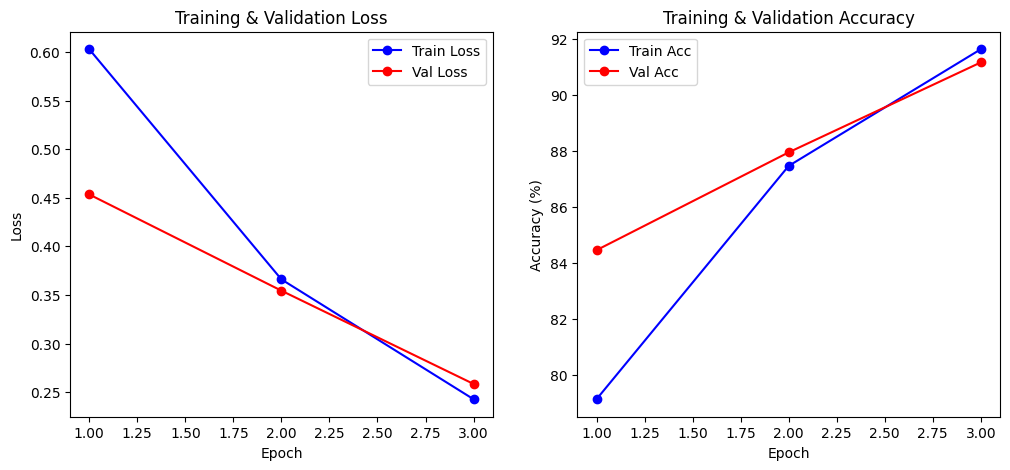

In [11]:
# 📈 Visualisasi hasil training
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, [a*100 for a in train_accs], 'b-o', label='Train Acc')
plt.plot(epochs, [a*100 for a in val_accs], 'r-o', label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [12]:
# --- Implementasi Waktu Inferensi & Hardware ---
def measure_inference_time(model, dataloader, device):
    model.eval()
    start_time = time.time()
    num_samples = 0

    # Hanya ukur waktu inferensi (forward pass)
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)
            num_samples += images.size(0)

    end_time = time.time()
    total_time = end_time - start_time
    avg_time_ms = (total_time / num_samples) * 1000
    throughput = num_samples / total_time

    return total_time, avg_time_ms, throughput, num_samples

total_inference_time, avg_inf_time_ms, throughput, num_samples_tested = measure_inference_time(model, val_loader, device)

print(f"Hardware Digunakan: **{device}**")
if device.type == 'cuda':
    print(f"Spesifikasi GPU: {torch.cuda.get_device_name(0)}")

print(f"Total Sampel yang Diuji: {num_samples_tested}")
print(f"Waktu Inferensi Total (seluruh test set): **{total_inference_time:.4f} detik**")
print(f"Waktu Inferensi Rata-rata per Gambar: **{avg_inf_time_ms:.4f} ms**")
print(f"Throughput (Gambar per Detik): **{throughput:.2f} img/detik**")


Hardware Digunakan: **cuda**
Spesifikasi GPU: Tesla T4
Total Sampel yang Diuji: 10000
Waktu Inferensi Total (seluruh test set): **19.6686 detik**
Waktu Inferensi Rata-rata per Gambar: **1.9669 ms**
Throughput (Gambar per Detik): **508.43 img/detik**


Overall Test Accuracy Akhir: **91.16%**

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

    airplane     0.9424    0.9000    0.9207      1000
  automobile     0.9455    0.9540    0.9497      1000
        bird     0.9450    0.8770    0.9098      1000
         cat     0.8232    0.8100    0.8165      1000
        deer     0.8924    0.9370    0.9141      1000
         dog     0.8173    0.8900    0.8521      1000
        frog     0.9644    0.9200    0.9417      1000
       horse     0.9042    0.9630    0.9327      1000
        ship     0.9562    0.9390    0.9475      1000
       truck     0.9411    0.9260    0.9335      1000

    accuracy                         0.9116     10000
   macro avg     0.9132    0.9116    0.9118     10000
weighted avg     0.9132    0.9116    0.9118     10000



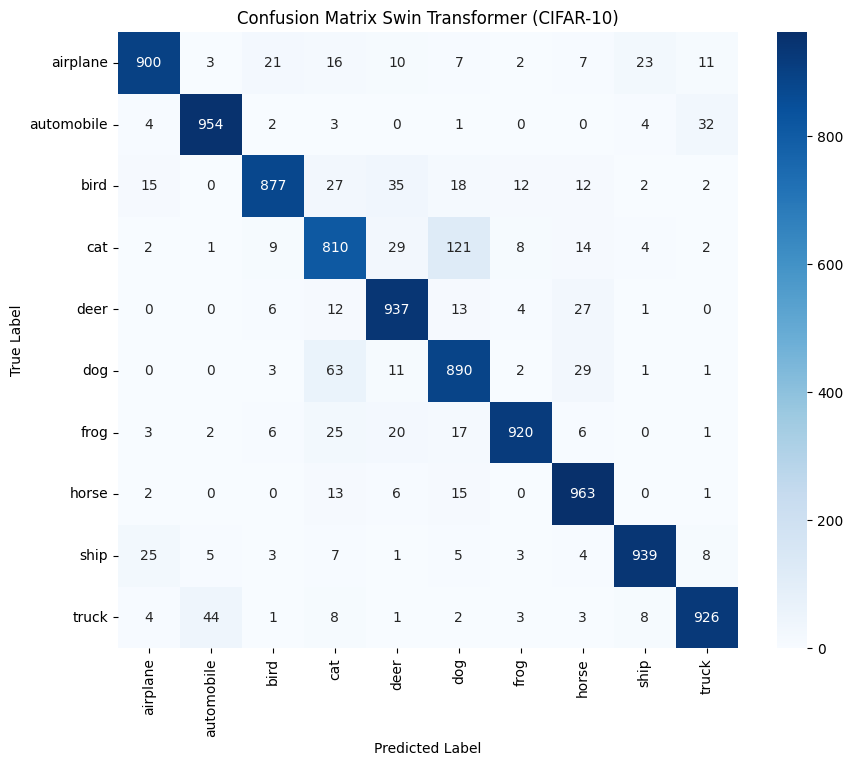

In [13]:
# --- Implementasi Metrik Performa & Confusion Matrix ---
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Collecting Predictions for Metrics"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung Akurasi Keseluruhan (Overall Accuracy)
overall_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"Overall Test Accuracy Akhir: **{overall_acc*100:.2f}%**")

# Classification Report (Precision, Recall, F1-Score per kelas & rata-rata)
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print("\nClassification Report (Precision, Recall, F1-Score):")
print(report)

# Confusion Matrix (Visualisasi)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix Swin Transformer (CIFAR-10)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

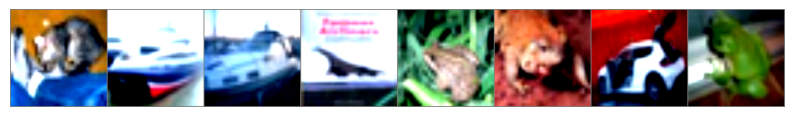

Ground Truth : ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']
Predictions  : ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


In [14]:
# Evaluasi model akhir dan tampilkan prediksi sampel
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print("Ground Truth :", [classes[labels[j]] for j in range(8)])
print("Predictions  :", [classes[preds[j]] for j in range(8)])

In [15]:
# Simpan model hasil training
#os.makedirs("checkpoints", exist_ok=True)
#torch.save(model.state_dict(), "checkpoints/swin_cifar10.pth")
#print("\n✅ Model disimpan ke checkpoints/swin_cifar10.pth")